In [5]:
import atomai as aoi
import numpy as np
import matplotlib.pyplot as plt
import nanonispy as nap
from scipy.ndimage import gaussian_filter
from scipy.fft import fftshift, fft2,ifftshift,ifft2,fft,fftfreq
from scipy.signal import hann
import pySPM
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
from os.path import join
from skimage.util import view_as_windows
import copy
import warnings
warnings.filterwarnings("ignore")

In [2]:
def slide_Win(image,window_size = (32, 32),stride = 32):
    image=image
    window_size = window_size
    stride = stride
    # Extract windows from the image
    windows = view_as_windows(image, window_size, stride)
    
    print("the shape of moving windows:", windows.shape)
    
    arg=[[60,60],[60,70],[60,65],[50,60],[60,63],[50,66],[60,40],[50,70],[60,20]]
    

    plt.figure(figsize=[15,15])
    for i in range(9):
        plt.subplot(3,3,i+1)
        plt.imshow(windows[arg[i][0]][arg[i][0]])
        plt.title("Slide Window No."+str(i))
    plt.subplots_adjust(wspace=0.3,hspace=0.3)
    plt.show()
    return windows
def recover_Win(windows,image,stride=32):
    recons_img=np.zeros(shape=image.shape)
    for x in range(windows.shape[0]):
        for y in range(windows.shape[1]):
            x_pos,y_pos=x*stride,y*stride
            recons_img[x_pos:x_pos+windows.shape[2], y_pos:y_pos+windows.shape[3]]=windows[x,y]
    plt.figure(figsize=(15,25))
    plt.subplot(1,2,1)
    plt.imshow(recons_img, cmap='gray')
    plt.title('Reconstructed Image')
    plt.axis('off')
    plt.subplot(1,2,2)
    plt.imshow(image, cmap='gray')
    plt.title('Original Image')
    plt.axis('off')
    print("the reconstructed image equal to original image:",(recons_img==image).all())
    return recons_img


def STS_images(sweep,omegaYArray,params):
    
    (raw,col,num)=omegaYArray.shape
    (raw,col,num_p)=params.shape
    Zs_image,params_image=[],[]
    for i in range(num):
        raw_filted=gaussian_filter((omegaYArray[:,:,i]), sigma=1)
        Zs_image.append(pySPM.SPM_image(raw_filted)) 
    for i in range(num_p):
        raw_filted=gaussian_filter((params[:,:,i]), sigma=1)
        params_image.append(pySPM.SPM_image(raw_filted)) 
    return Zs_image,params_image

def my_FFT(img):
    x_p=img.shape[0]
    image_bw=(img-img.min())/(img.max()-img.min())
    image_bw=img
    window_hann = image_bw * hann(x_p, sym=True)
    ft = np.fft.fftshift(np.fft.fft2(window_hann))
    power_spectrum = np.abs(ft) ** 2
    return (power_spectrum-power_spectrum.min())/(power_spectrum.max()-power_spectrum.min())

def read_grid_data(directory = "../STMdata/20221116",file = "014"):
    
    directory = directory
    fileName = "Grid Spectroscopy"
    file = file 
    filePath='{0}/{1}{2}.3ds'.format(directory,fileName,file)
    grid = nap.read.Grid(filePath) 
    sweep=grid._derive_sweep_signal()
    omegaYArray = grid._load_data()['LIY 1 omega (A)']
    params=grid._load_data()['params'] 
    return sweep,omegaYArray,params

def display_FT(Z_fft,fig,ax,x_n=20,x_p=256,zoomValue=80,title="FT image",cmap="gray_r"):
    x_n,y_n=x_n,x_n
    d=x_n/zoomValue #Sample spacing 
    y_p,x_p=x_p,x_p
    y_freq=np.fft.fftshift(np.fft.fftfreq(y_p,d)) 
    x_freq=np.fft.fftshift(np.fft.fftfreq(x_p,d)) 
    extent=[x_freq[0],x_freq[-1],y_freq[0],y_freq[-1]]
    #ax.axis("off")
    Z_fft=pySPM.zoom_center(Z_fft, sx=zoomValue, sy=zoomValue) 
    real={"x":-x_freq[0]+x_freq[-1],"y":y_freq[-1]-y_freq[0],"unit":"2pi/nm"} 
    Z_fft_image=pySPM.SPM_image(Z_fft,real=None) 
    scalebar2=AnchoredSizeBar(ax.transData,1/0.438/1.731,r'$1/3a^{-1}$',"lower right",pad=1,sep=3,color="black",label_top=True,frameon=False,size_vertical=0.05)
    #ax.add_artist(scalebar2)
    x=r'$q_x/2\pi$ $(nm^{-1})$'
    y=r'$q_y/2\pi$ $(nm^{-1})$'
    ax.set_xlabel(x)
    ax.set_ylabel(y)
    ax.set_title("The FFT image of kagome lattice") #ax2.set_extent(extent)
    img=ax.imshow(Z_fft,origin="lower",extent=extent,cmap=cmap)
    Vmin=np.ndarray.min(Z_fft_image.pixels) 
    Vmax=np.ndarray.max(Z_fft_image.pixels) 
    cb=fig.colorbar(img,ax=ax,orientation="vertical",pad=0.02,shrink=0.8) 
    cb.ax.yaxis.set_tick_params(size=0.8,labeltop=True) 
    cb.set_ticks([Vmax,Vmin])
    cb.set_ticklabels(["High","Low"])
    ax.set_title(title)
    
def display_topo(image,fig,ax,x_n,y_n,title="SiC",scalecolor="white",scalesize=0.3,cmap="Blues_r"):
    #image=gaussian_filter(image,sigma=1)
    Z_image= pySPM.SPM_image(image)
    #Z_image.correct_median_diff()
    #Z_image.correct_lines()
    (y_p,x_p)=image.shape
    Z_image.size["real"]["x"],Z_image.size["real"]["y"]=x_n*1e-9,y_n*1e-9
    Z_image.size["pixels"]["y"],Z_image.size["pixels"]["x"]=y_p,x_p
    img=Z_image.show(ax=ax,sig=None,cmap=cmap)
    ax.axis ('off')
    Vmin=np.ndarray.min(Z_image.pixels) 
    Vmax=np.ndarray.max(Z_image.pixels) 
    cb=fig.colorbar(img,ax=ax,orientation="vertical",pad=0.02,shrink=0.8) 
    cb.ax.yaxis.set_tick_params(size=0.8,labeltop=True) 
    cb.set_ticks([Vmax,Vmin])
    cb.set_ticklabels(["High","Low"])
    scale=int(x_n/10) 
    scalebar=AnchoredSizeBar(ax.transData,scale*2,"{0} nm".format(scale*2),"lower right",pad=1,sep=3,color=scalecolor,label_top=True,frameon=False,size_vertical=scalesize)
    #ax.add_artist(scalebar)
    ax.set_title(title) 
    return img


def read_file(filePath):
    SXMfile=pySPM.SXM(filePath)
    header=SXMfile.header
    Bias=header['BIAS'][0][0]
    Curr=header['Z-CONTROLLER'][1][3]
    Z_image=SXMfile.get_channel('Z')
    #Z_image.correct_median_diff()
    Z_image.correct_lines()
    x_n,y_n=Z_image.size["real"]["x"]*1e9,Z_image.size["real"]["y"]*1e9
    y_p,x_p=Z_image.size["pixels"]["y"],Z_image.size["pixels"]["x"]
    print("the file is {0},\r\nthe Bias is {1} V,the current is {4} A, the size is {2}*{2} nm,the resolution is {3}*{3} pix ".format(filePath,float(Bias),int(x_n),x_p,Curr))
    return Z_image,x_n


def displaySTS(directory = "../STMdata/20221116",file = "016",point=[35,35],bias_n=70,x_n=10):
    sweep,omegaYArray,params=read_grid_data(directory = directory,file =file)
    Zs_image,params_image=STS_images(sweep,omegaYArray,params)
    point=point
    bias_n=bias_n




    Z_image=params_image[4]
    Z_image.correct_median_diff()
    Z_image.correct_lines()
    image=Z_image.pixels[::-1,::-1]
    x_p,y_p=image.shape[0],image.shape[1]
    x_n,y_n=x_n,x_n
    zoomFactor=0.12
    zoomValue=int(x_p*zoomFactor)
    fig,ax = plt.subplots(1,2,figsize=(15,7))
    FFT_bw=my_FFT(image)
    image=(image-image.min())/(image.max()-image.min())
    LargeProfile=display_topo(image,fig,ax[0],x_n,y_n,title="",scalecolor="white",scalesize=0.15,cmap="Blues_r")
    index=x_n/x_p
    point_n=[point[0]*index,point[1]*index]
    ax[0].scatter(point_n[0],point_n[1],color="red",s=15)

    ax[1].scatter(point_n[0],point_n[1],color="red",s=15)
    figf,axf = plt.subplots(1,2,figsize=(15,7))
    display_FT(FFT_bw,figf,axf[0],x_n=20,x_p=256,zoomValue=80,title="FT image",cmap="gray_r")

    bias_v=(abs(sweep[-1]-sweep[0])*bias_n/sweep.shape)+sweep[0]
    print("bais=",bias_v,"x_p=",x_p,"sweep[-1]-sweep[0]",sweep[-1],sweep[0])
    Z_image=Zs_image[bias_n]
    Z_image.correct_median_diff()
    Z_image.correct_lines()
    image=Z_image.pixels[::-1,::-1]
    x_p,y_p=image.shape[0],image.shape[1]
    x_n,y_n=x_n,x_n
    zoomFactor=0.12
    zoomValue=int(x_p*zoomFactor)
    FFT_bw=my_FFT(image)
    image=(image-image.min())/(image.max()-image.min())
    LargeProfile=display_topo(image,fig,ax[1],x_n,y_n,title="",scalecolor="white",scalesize=0.15,cmap="Blues_r")
    display_FT(FFT_bw,figf,axf[1],x_n=20,x_p=256,zoomValue=80,title="FT image",cmap="gray_r")

    fig,ax = plt.subplots(1,1,figsize=(15,5))
    spec=ax.plot(sweep,omegaYArray[point[0]][point[1]]*1e12,color="lightblue")
    print(spec)
    line=ax.vlines(bias_v,ymin=0,ymax=(omegaYArray[point[0]][point[1]]*1e12).max())

the shape of moving windows: (143, 143, 8, 8)


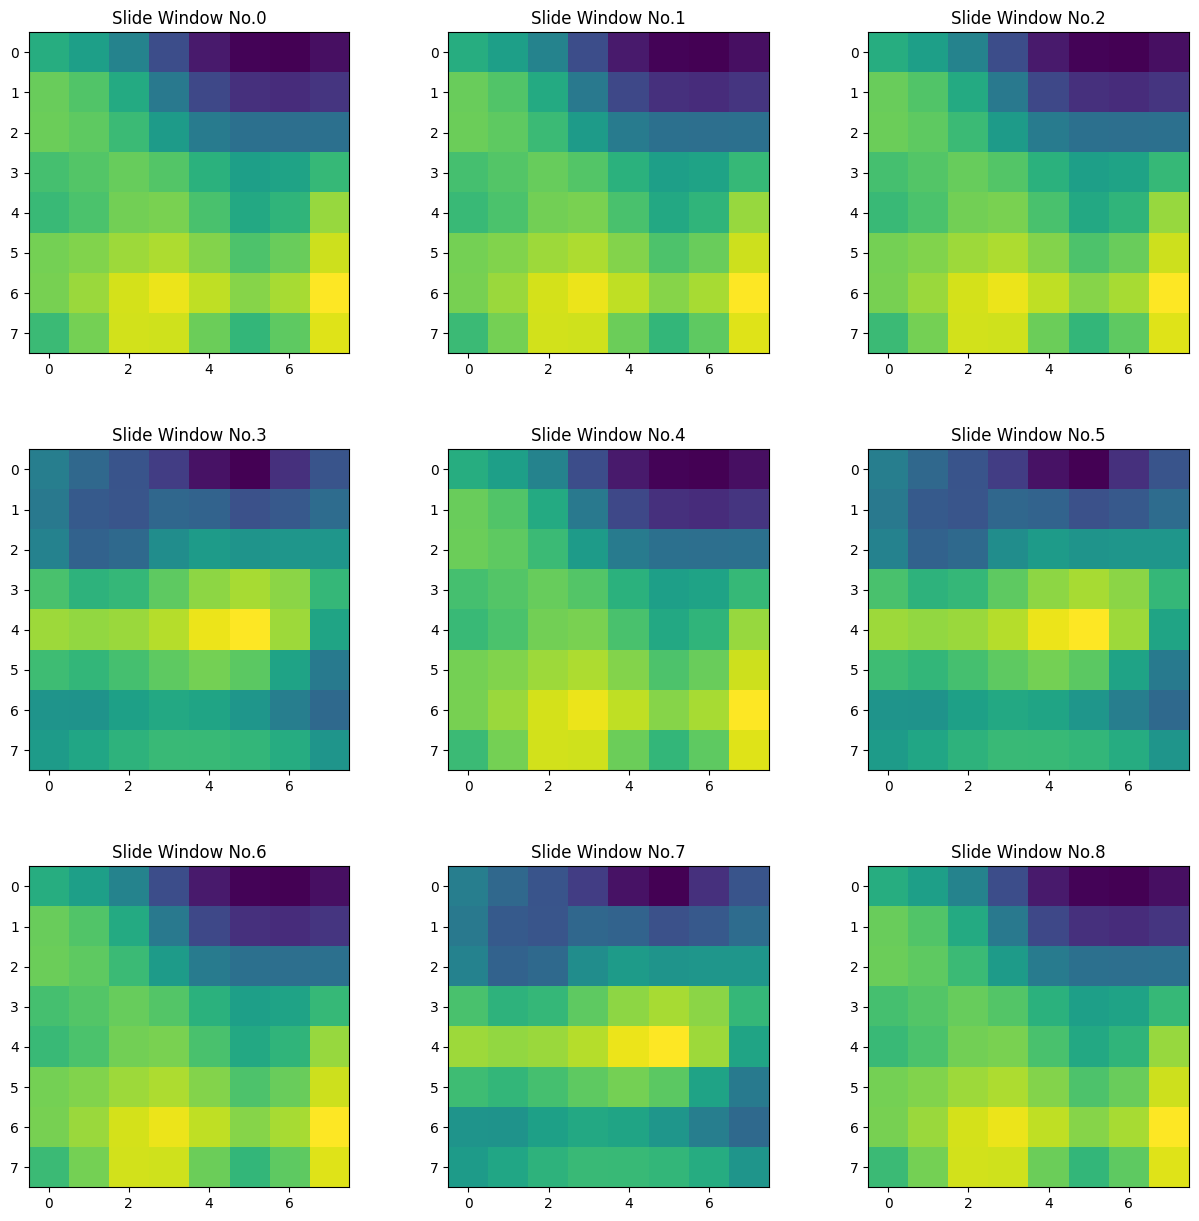

In [6]:
sweep,omegaYArray,params=read_grid_data(directory = "../../../STMdata/20221116",file ="016")
Zs_image,params_image=STS_images(sweep,omegaYArray,params)
Z_image=params_image[4]
Z_image.correct_median_diff()
Z_image.correct_lines()
image=Z_image.pixels[::-1,::-1]

window_size = (8, 8)
stride = 1
windows_FFT=slide_Win(image,window_size = window_size,stride = stride)

In [18]:
windows_FFT=windows_FFT.reshape(-1,windows_FFT.shape[2],windows_FFT.shape[2])
omegaYArray=omegaYArray.reshape(-1,omegaYArray.shape[-1])
imgs=windows_FFT[:20000]
spectra=omegaYArray[:20000]*1e12
specval=sweep
imgs= imgs.astype(np.float32)
spectra= spectra.astype(np.float32)
specval= specval.astype(np.float32)
print(imgs.shape)
print(spectra.shape)
print(specval.shape)

(20000, 8, 8)
(20000, 128)
(128,)


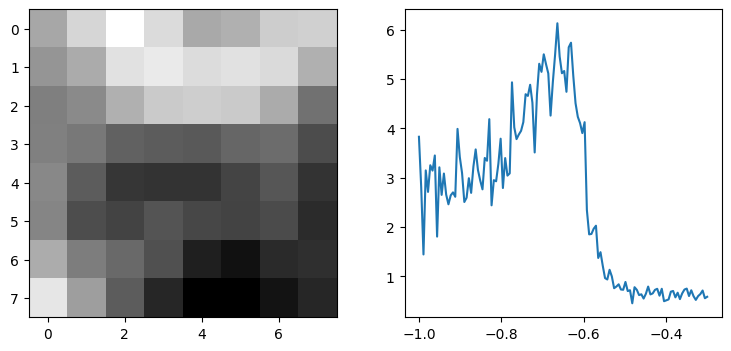

In [19]:
k = 35
_, (ax1, ax2) = plt.subplots(1, 2, figsize=(9, 4))
ax1.imshow(imgs[k], cmap='gray')
ax2.plot(specval[:], spectra[k])

In [20]:
imgs_train, spectra_train, imgs_test, spectra_test = aoi.utils.data_split(imgs, spectra, format_out="torch_float")

Epoch 1/120 ... Training loss: 9.5735 ... Test loss: 12.3283 ... GPU memory usage: N/A / N/A
Epoch 2/120 ... Training loss: 6.0898 ... Test loss: 5.6769 ... GPU memory usage: N/A / N/A
Epoch 3/120 ... Training loss: 3.1168 ... Test loss: 2.8369 ... GPU memory usage: N/A / N/A
Epoch 4/120 ... Training loss: 1.4268 ... Test loss: 7.0675 ... GPU memory usage: N/A / N/A
Epoch 5/120 ... Training loss: 0.6059 ... Test loss: 43.7158 ... GPU memory usage: N/A / N/A
Epoch 6/120 ... Training loss: 0.304 ... Test loss: 0.3397 ... GPU memory usage: N/A / N/A
Epoch 7/120 ... Training loss: 0.2358 ... Test loss: 21.036 ... GPU memory usage: N/A / N/A
Epoch 8/120 ... Training loss: 0.2265 ... Test loss: 77.7356 ... GPU memory usage: N/A / N/A
Epoch 9/120 ... Training loss: 0.2262 ... Test loss: 133.9056 ... GPU memory usage: N/A / N/A
Epoch 10/120 ... Training loss: 0.2261 ... Test loss: 0.861 ... GPU memory usage: N/A / N/A
Epoch 11/120 ... Training loss: 0.226 ... Test loss: 69.5467 ... GPU memory 

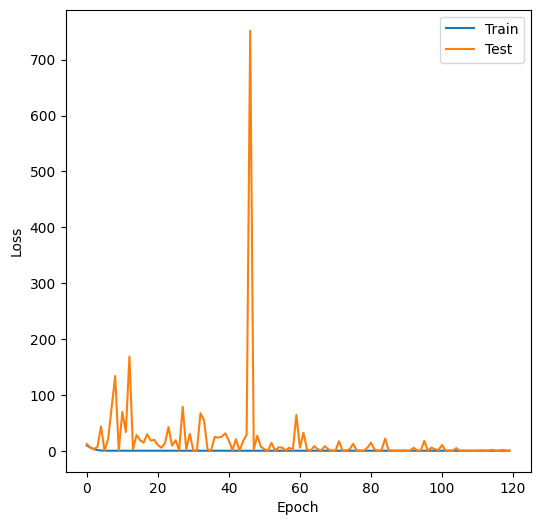

In [21]:
in_dim = (8, 8)
out_dim = (128,)

model = aoi.models.ImSpec(in_dim, out_dim, latent_dim=10, seed=2)

model.fit(imgs_train, spectra_train, imgs_test, spectra_test,  # training data
          full_epoch=True, training_cycles=120, swa=True, batch_norm=True)  # training parameters

In [22]:

prediction = model.predict(imgs_test, norm=False)

Batch 10/10
3000 images were decoded in approximately 2.7679 seconds


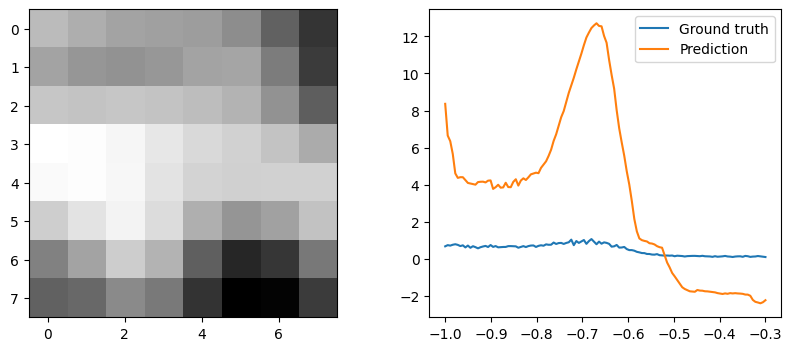

In [32]:
k = 180

_, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
ax1.imshow(imgs_test[k], cmap='gray', label="Input image")
ax2.plot(specval[:], spectra_test[k]/5, label="Ground truth")
ax2.plot(specval[:], prediction[k], label="Prediction")
plt.legend()
     